Epifluorescence beads (reconstruction)
--------------------------------------

This notebook uses the same data as the notebook `50.Sliding windows epifluorescence`, and uses the method developed in `51.2D PSF models`. It is organized in two successive parts:

1. The standalone code
2. Code to be run on a computing cluster

Again, analyses of the output are provided in a following notebook (`4b.Epifluorescence beads (analysis)`)

In [2]:
%matplotlib inline
import sys, os
import numpy as np
from libtiff import TIFF
import matplotlib.pyplot as plt
sys.path.append("../../3_code/")
import cstools
reload(cstools)

# useful function
def spiral(m, b):
    """Poisson likelihood objective function"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, noisetype='poisson')
def spiral2(m, b):
    """Gaussian likelihood objective function"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)
def spiral_tv(m, b): 
    """Total variation reconstruction"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, penalty='tv')

# Define paths
bn = "../../4_data/epifluorescence/161010_CS_beads_mega/"
p_psf = os.path.join(bn, "3_eye_3/Pos0_eye_PSF.tif")
p_eye = os.path.join(bn, "3_eye_3/Pos0_eye.tif")
p_fou = os.path.join(bn, "3_fourier_2/Pos0_cs.tif")

# load data
psf_f = cstools.read_tif(p_psf)
eye = cstools.read_tif(p_eye)
fou = cstools.read_tif(p_fou)

# Measurement matrix
b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)

# PSF extraction and saving

PSF saved on file ../../5_outputs/psf_models/epifluorescence_161121
(101, 32800) (1010, 3280)


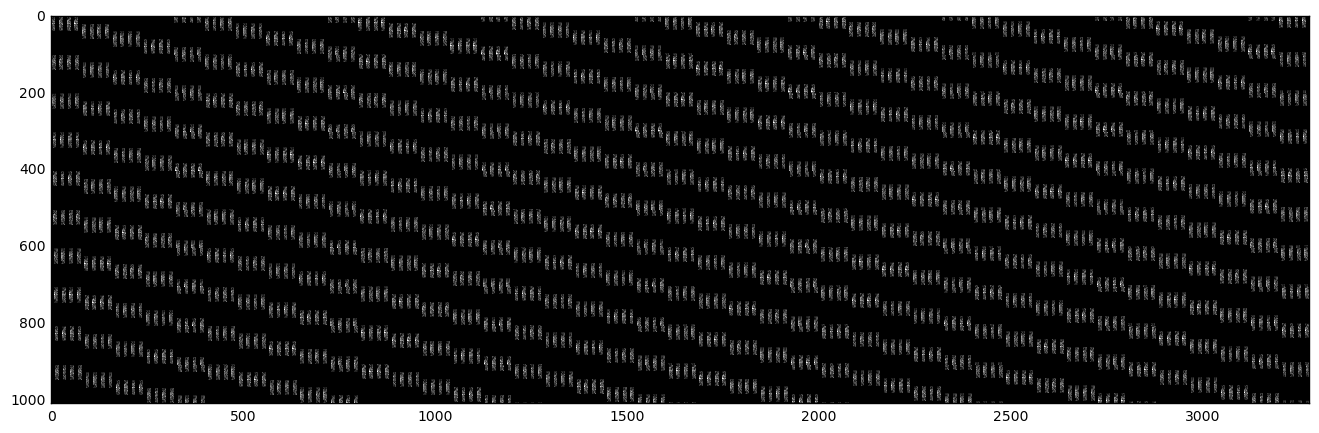

In [3]:
## 1. Extract a PSF
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../../5_outputs/psf_models/epifluorescence_161121" ## Set to None to avoid saving
load_psf = False ## Load the PSF from the save_psf file.
step = 20 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.

psf = psf_f[15:25,:,15:25].mean(0)
psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))    
else:
    print "Not saving the PSF"

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)


l=np.zeros((eye.shape[2], 2*psf.shape[1]))
l[:psf.shape[0],:psf.shape[1]]=psf
ll=[]
for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
    for k in range(2*psf.shape[0]):
        ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])

D1 = np.hstack(ll) ## This is the dictionary.
D2 = np.hstack([i.T.reshape((-1,1)) for i in ll])

print D1.shape, D2.shape
plt.figure(figsize=(18,5))
plt.imshow(D2, cmap='gray', interpolation="none")

# Reconstructing (desktop)

In [5]:
B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2)

## Apply the 2D model
# ==== 3. Subdivide the simulated image & reconstruct (with sliding windows)
def reco_image2(ima, verbose=True):
    im = np.zeros((ima.shape[0], b.shape[1]))
    vec_counts = np.zeros(ima.shape[0])
    for i in range(eye[0, :,:].shape[0]):
        if verbose and i%100 == 0:
            print "-- {}/{}".format(i, eye[0, :,:].shape[0])
        (sta,sto) = (i-psf.shape[1], i)
        im_sub = ima[range(sta,sto),:].flatten()
        r_sim = spiral2(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))        
        im[range(sta,sto),:]+=r_sim
        vec_counts[range(sta,sto)]+=1
        
    for (i,v) in enumerate(vec_counts): # Average each row
        im[i,:] /= v
    return im

im = reco_image2(fou[205,:,:])

-- 0/512


/usr/local/lib/python2.7/dist-packages/pySPIRALTAP-0.4.12-py2.7.egg/pySPIRALTAP/pySPIRALTAP.py:212: RuntimeWarning: divide by zero encountered in double_scalars


-- 100/512
-- 200/512
-- 300/512
-- 400/512
-- 500/512


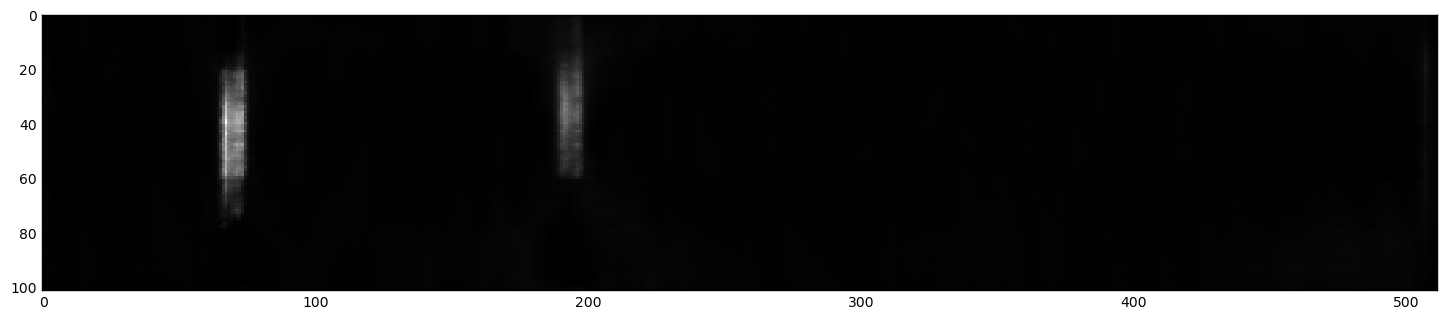

In [12]:
plt.figure(figsize=(18,6))
plt.imshow(im.T, cmap='gray', interpolation='none')

In [ ]:
## /!\ Be careful that this might take a lot of time
## Basically, this takes 512 times more time than the previous iteration
## /!\ ONCE AGAIN, 3'x512 = 1500' = ONE DAY
## A cluster version is provided below, consider it before doing weird things.

# Launch a full stack reconstruction
im3d = []
for i in range(fou.shape[0]):
    if i%10 == 0:
        print "{}/{}".format(i, fou.shape[0])
    im = reco_image2(fou[i,:,:], verbose=False)
    im3d.append(im)

In [ ]:
iff = TIFF.open("./img/paper4.epifluorescence_rec_avg.tif", "w")
iff.write_image([(101*j).astype(np.uint16) for j in im3d])
iff.close()

# A cluster-ready version
## How to use it?

1. Copy the code in the appropriate directory (`../8_cluster/tars/08_epifluorescence/`)
2. Copy the data to the right paths
3. Log on `tars`

```{shell}
mkdir ../5_outputs/11_reconstructions_march_epifluorescence ## Create the output folder
module load Python/2.7.11

## Progressive test procedure
srun ~/.envs/dict-optim/bin/python ../8_cluster/tars/08_epifluorescence/reconstruction4.py 0 

```

4. Launch the real reconstructions: `./../8_cluster/tars/08_epifluorescence/reconstruction4.sh`
5. Recombine the images in a TIFF file: `python ../8_cluster/tars/08_epifluorescence/recombine.py rec ../5_outputs/11_reconstructions_march_epifluorescence/`

## The code

There is one critical parameter that was varied to generate Figure 4. This parameter is the number of measurements to take into account for the reconstruction: change the `n_mes` variable accordingly (was tuned from 2 to 50, corresponding to a compression/speedup of 2 to 50).

In [6]:
%%writefile ../../8_cluster/tars/08_epifluorescence/reconstruction4.sh
#!/bin/sh
## /!\ This code is generated by a Jupyter script, do not edit it directly.
## It is designed to run reconstructions on a very specific dataset.
## It should be adapted carefully before playing on the input stuff

echo "==== DISCLAIMER ===="
echo "Have you installed the following packages?: virtualenv, numpy, scipy libtiff, joblib, pycsalgos, h5py, pySPIRALTAP"
echo "Have you run the following commands to load the packages?"
echo "$ module load Python/2.7.11"
echo "$ source ~/.local/bin/virtualenvwrapper.sh"
echo "$ export WORKON_HOME=~/.envs"
echo "$ workon dict-optim"

N_FRAMES_IN_STACK=512
email="maxime.woringer@pasteur.fr"
maxparalleljobs=100

echo 'Running on tars'
sbatch --mail-type=BEGIN,END --mail-user=$email --array=0-$N_FRAMES_IN_STACK%$maxparalleljobs ../8_cluster/tars/08_epifluorescence/reconstruction4_init.sh

Writing ../../8_cluster/tars/08_epifluorescence/reconstruction4.sh


In [16]:
%%writefile ../../8_cluster/tars/08_epifluorescence/reconstruction4_init.sh
#!/bin/sh
#SBATCH --qos=fast 
#SBATCH -N 1
#SBATCH -c 12
#SBATCH -p common,dedicated
#SBATCH -o ../8_cluster/tars/06_reconstruct_3d/log_reconstruction.log -e ../8_cluster/tars/06_reconstruct_3d/log_reconstruction.err
# By Maxime W., Nov. 2016, GPLv3+
# /!\ DO NOT EDIT THIS FILE. IT HAS BEEN GENERATED BY A SCRIPT
# Script is ../2_simulations/51. ...ipynb

## This script to be called by SBATCH, do not call it directly, it will not work.
srun ~/.envs/dict-optim/bin/python ../8_cluster/tars/08_epifluorescence/reconstruction4.py ${SLURM_ARRAY_TASK_ID}

Overwriting ../../8_cluster/tars/08_epifluorescence/reconstruction4_init.sh


In [18]:
%%writefile ../../8_cluster/tars/08_epifluorescence/reconstruction4.py

import sys, os
import numpy as np
from libtiff import TIFF
sys.path.append("../3_code/")
import cstools
#reload(cstools)

n_mes = 50 ## Compression factor (a number of frames)
save_prefix = "epifluorescence{}".format(n_mes)


## tars-specific parameters
frame_to_reconstruct = int(sys.argv[1])


# useful function
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)

# Define paths
bn = "../4_data/epifluorescence/161010_CS_beads_mega/"
p_psf = os.path.join(bn, "3_eye_3/Pos0_eye_PSF.tif")
p_eye = os.path.join(bn, "3_eye_3/Pos0_eye.tif")
p_fou = os.path.join(bn, "3_fourier_2/Pos0_cs.tif")

out_folder = "../5_outputs/11_reconstructions_march_epifluorescence"

## Do not reconstruct if we already have it
if os.path.exists(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct))):
    print "reconstruction {} exists, aborting".format("{}.{}.txt".format(save_prefix, frame_to_reconstruct))
    sys.exit(0)

# load data
psf_f = cstools.read_tif(p_psf)
eye = cstools.read_tif(p_eye)
fou = cstools.read_tif(p_fou)

###
### ===================== Extract a PSF and build measurement matrix
###
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../5_outputs/psf_models/epifluorescence_161121" ## Set to None to avoid saving
load_psf = False ## Load the PSF from the save_psf file.
step = 20 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.

psf = psf_f[15:25,:,15:25].mean(0)
psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))    
else:
    print "Not saving the PSF"

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)


l=np.zeros((eye.shape[2], 2*psf.shape[1]))
l[:psf.shape[0],:psf.shape[1]]=psf
ll=[]
for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
    for k in range(2*psf.shape[0]):
        ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])

D1 = np.hstack(ll) ## This is the dictionary.
D2 = np.hstack([i.T.reshape((-1,1)) for i in ll])
    
###
### ======================== Generate stuff
###

## Generate measurement matrix
# Generate basis
if n_mes == 0:
    b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
else:
    print "Truncating"
    b=cstools.generate_fourier_basis(101, n_mes+1, sample=False, oldmethod=True)
    fou = fou[:,:,:n_mes]

B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2)

## Apply the 2D model
# ==== 3. Subdivide the simulated image & reconstruct (with sliding windows)
def reco_image(ima, verbose=True):
    im = np.zeros((ima.shape[0], b.shape[1]))
    vec_counts = np.zeros(ima.shape[0])
    for i in range(eye[0, :,:].shape[0]):
        if verbose and i%100 == 0:
            print "-- {}/{}".format(i, eye[0, :,:].shape[0])
        (sta,sto) = (i-psf.shape[1], i)
        im_sub = ima[range(sta,sto),:].flatten()
        r_sim = spiral2(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))        
        im[range(sta,sto),:]+=r_sim
        vec_counts[range(sta,sto)]+=1
        
    for (i,v) in enumerate(vec_counts): # Average each row
        im[i,:] /= v
    return im
###
### =========================== Reconstruction step
###
print "Reconstructing"
im = reco_image(fou[frame_to_reconstruct,:,:], verbose=False) # Launch a full stack reconstruction

###
### =========================== Saving step
###
np.savetxt(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct)), im)

Overwriting ../../8_cluster/tars/08_epifluorescence/reconstruction4.py


# Recombine the .txt file in one .tiff file

Note that the dimensions of the output images are hardcoded (look at `dim1` and `dim2` variables). You might have to transpose the output if your reconstructions are along the wrong dimension).

In [19]:
%%writefile ../../8_cluster/tars/08_epifluorescence/recombine.py
## Maxime W., Jul 2016, GPLv3+
## This is actually the worker to combine the movie to a 3D stack

# ==== Imports
import sys, os
import numpy as np
from libtiff import TIFF

dim1 = 512
dim2 = 101
scl = 1000 # Multiply by this factor before saving.


print "Saving a stack of {} elements, {} px".format(dim2, dim1)

# ==== Variables
(none, frame_bn, out_dir) = sys.argv
tmp_dir = os.path.join(out_dir, '')
out_file = os.path.join(out_dir, "{}.tif".format(frame_bn))
remove_neg = True # if True, negative elements in the reconstruction will be set to zero.

# ==== Checking inputs
## Input files
inp_files = [i for i in os.listdir(tmp_dir) if i.startswith(frame_bn)]
if inp_files == []:
    raise IOError('No files found in {} with name starting with {}. ABORTING'.format(tmp_dir, frame_bn))
    
## Output file
if os.path.isfile(out_file):
    im = TIFF.open(out_file, 'r')
    for i in im.iter_images():
        frame0=i
        break
    im.close()
    if frame0.shape[0] >= len(inp_files):
        print "A TIFF stack already exists and has at least as many pixels as what we"
        print "were aiming to reconstruct. EXITING."
        sys.exit(0)

## ==== Saving image
print('Image dimensions are hardcoded so far. I know this is stupid.')
idx = [int(i.split('.')[-2]) for i in inp_files]
lf = sorted(zip(inp_files, idx), key=lambda x: x[1])
im = np.zeros((len(lf), dim1, dim2))
for (i,j) in enumerate(lf):
    f=np.genfromtxt(os.path.join(tmp_dir, j[0]))
    im[i,:,:]=f.T
print "Loaded {} planes".format(len(lf))

if remove_neg:
    print "Negative elements were set to zero"
    im[im<0]=0 ## Bruteforce.
tif = TIFF.open(out_file, 'w')
tif.write_image(np.array(np.int_(im*scl).swapaxes(2, 0).swapaxes(1,2), dtype=np.uint16))
tif.close()

Overwriting ../../8_cluster/tars/08_epifluorescence/recombine.py


In [ ]:
cstools.read_tif